Predictions of Annual Medical Expenditure
---

Thao Tran

## Introduction



In this analysis, we use neural networks to provide predictions on annual insurance premium (amount paid every month) offered to the customer based on their age, sex, BMI, children, smoking habits and region of residence. The goal is to estimate annual medical expenditure for new customers using the above measures. Our data of over 1300 customers comes from Kaggle, ["Medical Insurance Payout"](https://www.kaggle.com/datasets/harshsingh2209/medical-insurance-payout?resource=download), with the following variables:


* `age`: Age of the customer
* `sex`: Gender
* `bmi`: Body Mass Index, an important health factor
* `children`: Number of children
* `smoker`: Whether the customer smokes or not
* `region`: Region of the country the customer resides
* `charges`: The annual insurance expenditure for the customer



In [60]:
#load library
import numpy as np
import pandas as pd
import sklearn.model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#plots
import seaborn as sns
import matplotlib.pyplot as plt
# Keras
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
## Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

In [2]:
#load data
med = pd.read_csv("expenses.csv")
med.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Exploratory Data Analysis



We have 1338 records of customers, who have an average age of 39 and bmi of 31. There is an even distrbution of observations across sex and four regions, and about a fifth of customer records are smokers.  

In [3]:
med.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [4]:
med.describe(include = ['object'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Our target variable, `charges`, is unimodal and right-skewed with an average of \$13,270.42 and standard deviation of \$12,110.01. While the annual medical expenditure ranges from \$1,121.87 and \$63,770.43, its distribution can be distinguished between smokers (higher charges) and non-smokers (lower charges). The box plots of charges by `smoker` also shows that the mean expenses for smokers are significantly higher than the mean expenses for non-smokers. 

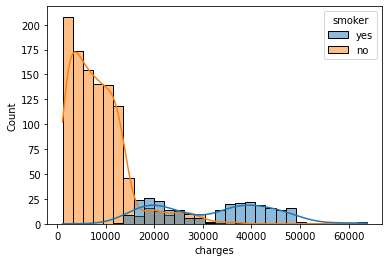

In [5]:
sns.histplot(data=med, x="charges",kde=True, hue = "smoker")

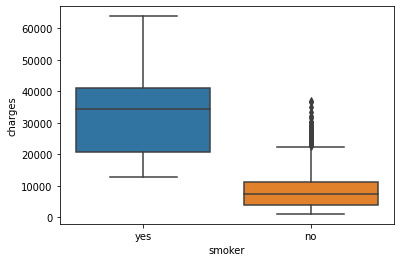

In [6]:
sns.boxplot(x="smoker", y="charges", data=med)

We also explore the relationship between `charges` and other variables and whether they are indicative of insurance payout in addition to `smoker`. The scatter plot between `age` and `charges` shows that there is an increasing trend where people at higher age experience higher expenses. The points form three increasing trends at different levels of charges. While `smoker` does help explain seprate some of these levels, there is other underlying patterns in place that we need to explore. 

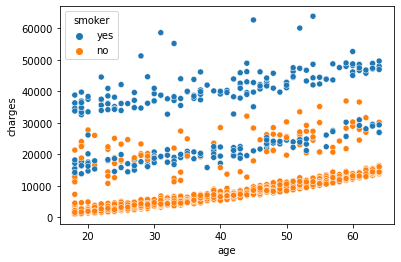

In [7]:
sns.scatterplot(data=med, x="age", y="charges",hue = "smoker")

Body mass index, `bmi`, is a person's weight divided by the square of height in meters. It is used as a screening tool for obesity and an important indicator for various metabolic and disease outcomes. In our analysis, we do not observe a linear relationship between `bmi` and `charges` however there are identifiable clusters. While bmi is not indicative of expenses for non-smokers whose records under \$15,000. Among smokers, those with bmi under 30 have medical payout between \$15,000 and \$30,000 and those with bmi above 30 have payout more than \$30,000.  

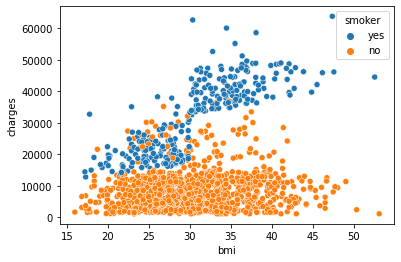

In [8]:
sns.scatterplot(data=med, x="bmi", y="charges",hue = "smoker")

As we further investigate with box plots of medical expenses by sex, number of children, and regions, we find no clear evidence that these variable are predictive of `charges`.

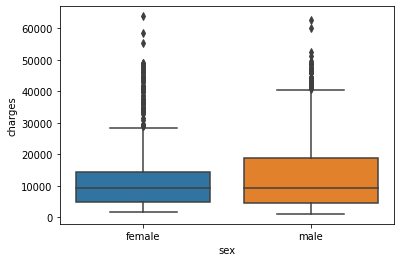

In [9]:
sns.boxplot(x="sex", y="charges", data=med)

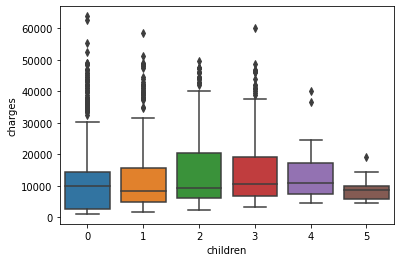

In [10]:
sns.boxplot(x="children", y="charges", data=med)

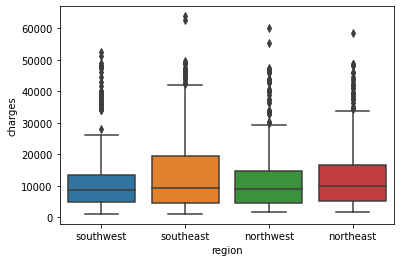

In [11]:
sns.boxplot(x="region", y="charges", data=med)

## Neural Networks Using Pytorch

In [12]:
#convert object to numeric 
med['sex'] = pd.factorize(med.sex)[0]
med['smoker'] = pd.factorize(med.smoker)[0]
med['region'] = pd.factorize(med.region)[0]

In [13]:
#scaler
scalar = MinMaxScaler()
scalar.fit(med['charges'].values.reshape(-1, 1))
# split data into training and testing sets
y = scalar.transform(med['charges'].values.reshape(-1, 1))
x = med.drop('charges',axis=1)
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y,random_state = 0, test_size = 0.2)

In [14]:
#set up model
def train_epoch(model, opt, criterion, X_train, y_train):
    model.train()
    losses = []
    opt.zero_grad()
    # (1) Forward
    y_hat = model(X_train)
    # (2) Compute diff
    loss = criterion(y_hat, y_train)
    # (3) Compute gradients, this is the backprop step
    loss.backward()
    # (4) update weights
    opt.step()        
    losses.append(loss.data.numpy())
    return losses

def train_epoch(model, opt, criterion, X_train, y_train):
    model.train()
    losses = []
    opt.zero_grad()
    # (1) Forward
    y_hat = model(X_train)
    # (2) Compute diff
    loss = criterion(y_hat, y_train)
    # (3) Compute gradients, this is the backprop step
    loss.backward()
    # (4) update weights
    opt.step()        
    losses.append(loss.data.numpy())
    return losses

class DeepNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(6, 6)
        # Output layer
        self.output = nn.Linear(6, 1)
        # Define sigmoid activation and softmax output 
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.relu(x)
        # notice how we just add another hidden unit layer
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x



In [65]:
net = DeepNetwork()
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()
x_train_tensor = torch.tensor(x_train.values)
y_train_tensor = torch.tensor(y_train)#.type(torch.LongTensor).unsqueeze(1)
e_losses = []
num_epochs = 5
for e in range(num_epochs):
    e_losses += train_epoch(net, opt, criterion, x_train_tensor.float(), y_train_tensor.float())
y_predict = net(torch.tensor(x_test.values).float()).detach().numpy()
#y_predict = (output.detach().numpy() > 0.5).astype("int32")
#r squared
mean_squared_error(y_test, y_predict)

0.10404227095689544

### Variables Importance

In [62]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 14.3 MB/s 


In [67]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt

test_input_tensor = torch.from_numpy(x_train.to_numpy()).type(torch.FloatTensor)

ig = IntegratedGradients(net)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=0, return_convergence_delta=True)
attr = attr.detach().numpy()

def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)


Average Feature Importances
age :  -0.416
sex :  -0.008
bmi :  0.294
children :  0.005
smoker :  0.013
region :  -0.011


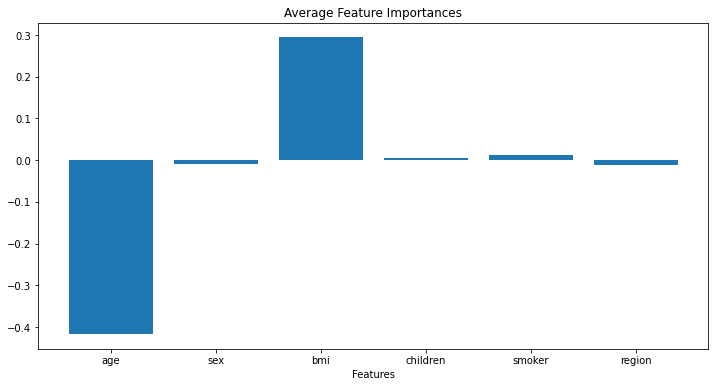

In [68]:
feature_names = list(x_train.columns.values)
visualize_importances(feature_names, np.mean(attr, axis=0))